<h1>A Human-Horse Binary Classification Model Using Convolutional Neural Networks</h1>

Our goal is to build a Convolutional Neural Network that receives computer generated images of horses and humans as training samples and classifies them accordingly. First, we need to download the dataset containing the images from the url below and unzip the files to a local directory.

In [6]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

--2021-07-15 08:02:13--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2800:3f0:4004:80b::2010, 2800:3f0:4004:808::2010, 2800:3f0:4004:809::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2800:3f0:4004:80b::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  14.5MB/s    in 9.9s    

2021-07-15 08:02:24 (14.4 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



In [10]:
import os
import zipfile

localDir = os.getcwd() + '/tmp/horse-or-human'
localZip = '/tmp/horse-or-human.zip'
zipRef = zipfile.ZipFile(localZip, 'r')
zipRef.extractall(localDir)
zipRef.close()

<h3>Directory Struture and File Contents</h3>

The contents of the .zip are extracted to the base directory `/tmp/horse-or-human`, which in turn each contain horses and humans subdirectories. The directory structure is as follows: The images are divided in the subdirectories /Training and /Validation. Each subdirectory contains other two subdirectories, one for humans and the other for horses.  The images of horses and humans have diferent sizes and ratios, which are going to be rescaled in later.

However, in this first section we're going to create only a training set and test the CNN directly by uploading images to it. The validation set will be downloaded and used in our model in the second part of this notebook.

Unlike the MNIST dataset, in this case, we are using unlabeled data. So, by using the ImageGenerator from Keras.preprocessing.image, the labels for horses and humans will be automatically generated according to the folder they're in. The names of the sub-directories will be the labels for the images that are contained within them. 

Now let's create some variables to store the directory paths and show filenames of the first 10 images of the training set.

In [13]:
trainHorseDir = os.path.join(localDir, 'horses')

trainHumanDir = os.path.join(localDir, 'humans')

trainHorseFilenames = os.listdir(trainHorseDir)
trainHumanFilenames = os.listdir(trainHumanDir)

print(trainHorseFilenames[:10])
print(trainHumanFilenames[:10])

['horse19-1.png', 'horse35-2.png', 'horse18-8.png', 'horse39-6.png', 'horse20-5.png', 'horse15-8.png', 'horse30-5.png', 'horse03-0.png', 'horse41-5.png', 'horse42-5.png']
['human14-20.png', 'human11-22.png', 'human13-10.png', 'human14-08.png', 'human07-17.png', 'human01-26.png', 'human06-29.png', 'human10-17.png', 'human10-09.png', 'human05-27.png']


Let's see the total numer of horse and human images in the directories:

In [14]:
print('total training horse images:', len(os.listdir(trainHorseDir)))
print('total training human images:', len(os.listdir(trainHumanDir)))

total training horse images: 500
total training human images: 524


<h3>Visualizing the Training Images</h3>
Now we're going to take a look at a few pictures to get a sense of how they look like. We'll set the matplotlib parameters to display 4x4 images. Then a batch of 8 horse and 8 human pictures is shown.

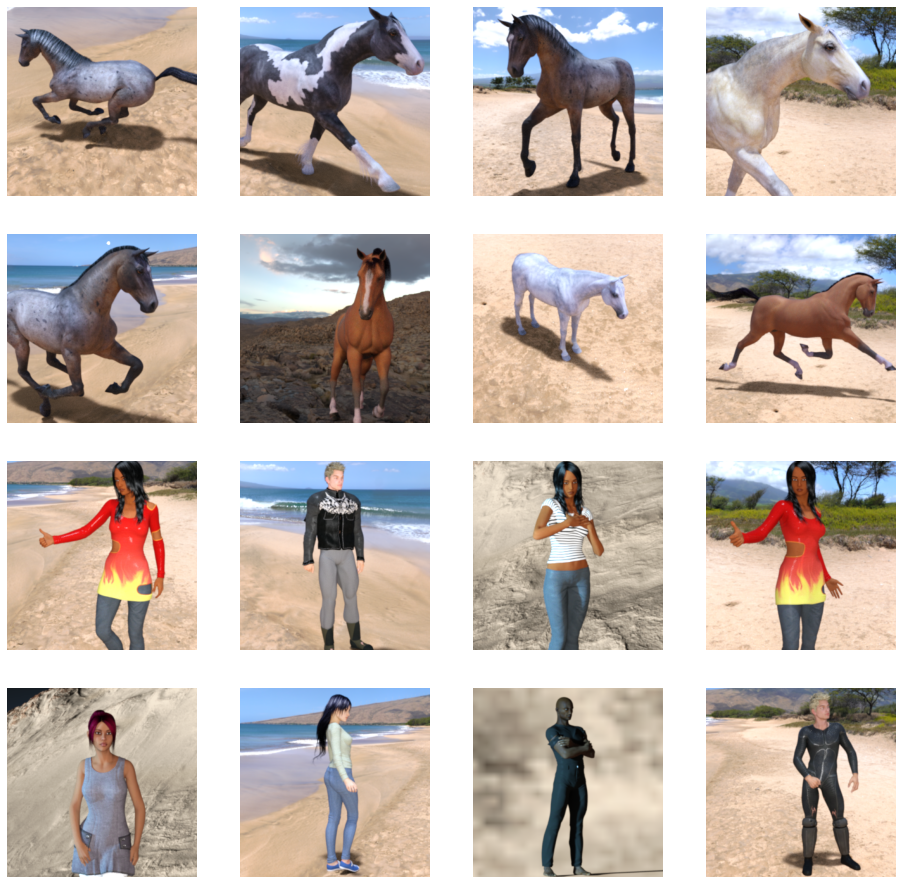

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = 4
ncols = 4

# Index for iterating over images
index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

index += 8

nextHorse = [os.path.join(trainHorseDir, fname) for fname in trainHorseFilenames[index-8:index]]
nextHuman = [os.path.join(trainHumanDir, fname) for fname in trainHumanFilenames[index-8:index]]

#enumerate returns the index of the image and its path for processing
for i, imgPath in enumerate(nextHorse + nextHuman):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') 

    #the mpimg module suports basic image loading, rescaling and display operations
    #imread reads an image from a file into a array. It receives a filename, url or binary object
    img = mpimg.imread(imgPath)
    plt.imshow(img)

plt.show()

We can see that the subjects have different positions and are placed in different locations, with diverse backgrounds and slight variations in lighting.

<h2>Building a Simple Model</h2>

This is a sequential model with 5 sets of convolutions and pooling.

The pictures were resized during the loading phase, so in the first layer, the input shape recieves 300x300 images. As these are colored images, they are represented by 3 matrices corresponding to Red, Green and Blue intensity values, as in the following example:

![RGB Matrices](files/rgb_image_matrix.png)

Then these intensity values from 0 to 255 are transformed into a feature vector X corresponding to the picture. The total dimension of this input feature vector is 300 x 300 x 3. 

X = \begin{vmatrix}
255 \\
251 \\
 .  \\
 .  \\
 .  \\
134 \\
202 \\
 .  \\
 .  \\
 
\end{vmatrix}

In binary classification, a single training example is represented by $ (x, y) $ where $x\in\mathbb{R}^{\eta_x}$, where the label $y \in \{0, 1\}$. The training sets will comprise $m$ training examples: $(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), ..., (x^{(m)}, y^{(m)})\}$

The training sets may be represented by a matrix, 

X = \begin{vmatrix}
. & . & ... & .\\
. & . & ... & .\\
x^{(1)} & x^{(2)} & ... & x^{(m)}\\
. & . & ... & .\\
. & . & ... & .\\ 
\end{vmatrix}


with $m$ columns and $\eta_x$ rows. Therefore, $X\in\mathbb{R}^{\eta_x * m}$.

In Python, `X.shape()` returns the dimensions of the matrix, denoted by $(\eta_x, m)$.

The output labels are represented by $Y = [y^{(1)}, y^{(2)},... ,y^{(m)}]$, where
$Y\in\mathbb{R}^{1*m}$. Its shape can be retrieved by `Y.shape()`, returning $(1, m)$.
<br />

<h3>2D convolution layer (e.g. spatial convolution over images)</h3>
This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs.

<h3>Max Pooling</h3>
Maximum Pooling calculates the maximum value for each patch of the feature map. 

It downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. The window is shifted by strides along each dimension.

This means that the pooling layer will always reduce the size of each feature map by a factor of 2, e.g. each dimension is halved, reducing the number of pixels or values in each feature map to one quarter the size. For example, a pooling layer applied to a feature map of 6×6 (36 pixels) will result in an output pooled feature map of 3×3 (9 pixels). The result of using a pooling layer and creating down sampled or pooled feature maps is a summarized version of the features detected in the input.

![MaxPooling](files/pooling.gif "segment")










<h3>Layer.Flatten</h3>
After 5 sets of Convolution and MaxPooling layers, the DNN flattens the input. 

A flatten layer collapses the spatial dimensions of the input into the channel dimension. In other words, flattening a tensor means to remove all of the dimensions except for one.

A Flatten layer in Keras reshapes the tensor to have a shape that is equal to the number of elements contained in the tensor. This is the same thing as making a 1d-array of elements.

![Flatten](files/flattening.png "segment")

<h3>Sigmoid Activation Function</h3>

In our final layer, this time we're using a sigmoid activation function. Because this is a binary classification task, we use sigmoid function is because it exists between (0 to 1). Therefore, it is especially used for models where we have to predict the probability as an output.Since probability of anything exists only between the range of 0 and 1, sigmoid is the right choice.

![Sigmoid](files/sigmoid.png "segment")

In [16]:

import tensorflow as tf

model = tf.keras.models.Sequential([  
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)), #1
    tf.keras.layers.MaxPooling2D(2, 2), 
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),#2
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'), #3
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'), #4
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'), #5 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])
    

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 33, 33, 64)        3

The <b>output shape</b> column shows how the size of our feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the dimensions

Next, we'll configure the model training. The binary_crossentropy loss will be used, for it computes the cross-entropy loss between true labels and predicted labels. And, as we mentioned above, the final activation function is a sigmoid.

We will use the rmsprop optimizer with a learning rate of 0.001. Using the RMSprop optimization algorithm is preferable to stochastic gradient descent (SGD), because RMSprop automates learning-rate tuning for us. During training, we will want to monitor classification accuracy.

In [17]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])

<h3>Data Preprocessing</h3>
In this step, data generators that will read pictures in our source folders, convert them to float32 tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of images of size 300x300 and their labels (binary).

The images will be preprocessed by normalizing the pixel values to be in the \[0, 1\] range (originally all values are in the \[0, 255\] range).

In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class using the rescale parameter. 

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainDataGen = ImageDataGenerator(rescale=1./255)

trainGen = trainDataGen.flow_from_directory(
        localDir,
        target_size=(300, 300),
        batch_size=128,
        class_mode='binary')

Found 1024 images belonging to 2 classes.


<h2>Training Phase</h2>

The Loss and Accuracy indicate the progress of training. It's making a guess as to the classification of the training data, and then measuring it against the known label, calculating the result. Accuracy is the portion of correct guesses.

In [19]:
history = model.fit(trainGen, steps_per_epoch=8, epochs=15, verbose=1)

Epoch 1/15
8/8 [==============================] - 68s 8s/step - loss: 0.8021 - accuracy: 0.4922
Epoch 2/15
8/8 [==============================] - 68s 8s/step - loss: 0.6594 - accuracy: 0.6328
Epoch 3/15
8/8 [==============================] - 67s 8s/step - loss: 0.9060 - accuracy: 0.7402
Epoch 4/15
8/8 [==============================] - 67s 8s/step - loss: 0.4329 - accuracy: 0.8447
Epoch 5/15
8/8 [==============================] - 68s 8s/step - loss: 0.2150 - accuracy: 0.9131
Epoch 6/15
8/8 [==============================] - 67s 8s/step - loss: 0.1484 - accuracy: 0.9424
Epoch 7/15
8/8 [==============================] - 68s 8s/step - loss: 0.3866 - accuracy: 0.8525
Epoch 8/15
8/8 [==============================] - 70s 9s/step - loss: 0.2042 - accuracy: 0.9189
Epoch 9/15
8/8 [==============================] - 74s 9s/step - loss: 0.0945 - accuracy: 0.9668
Epoch 10/15
8/8 [==============================] - 69s 8s/step - loss: 0.0324 - accuracy: 0.9893
Epoch 11/15
8/8 [======================

Our model finished training with an accuracy of 99%

In [23]:
import matplotlib.pyplot as plt

def showTrainingHistory(h):
    
    plt.figure(1)
    # summarize history for accuracy
    plt.subplot(211)
    plt.plot(h.history['accuracy'])
    #plt.plot(h.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training'], loc='lower right')

    # summarize history for loss
    plt.subplot(212)
    plt.plot(h.history['loss'])
    #plt.plot(h.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training'], loc='upper right')

    plt.tight_layout()

    plt.show()

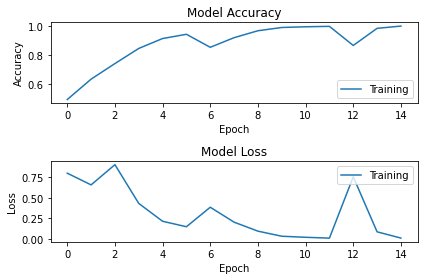

In [24]:
showTrainingHistory(history)

<h2>Running the Model and Making Predictions</h2>

This code allows to choose 1 or more files from the internet, it will then upload them, and run them through the model, giving an indication of whether the object is a horse or a human.

In [73]:
#url = input("Please enter an image url: ").strip()

[0.]


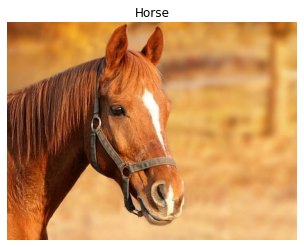

[0.]


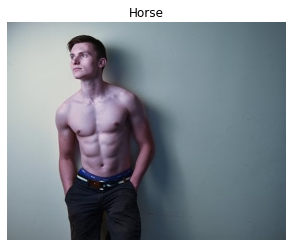

[1.]


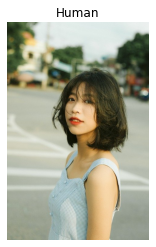

[0.]


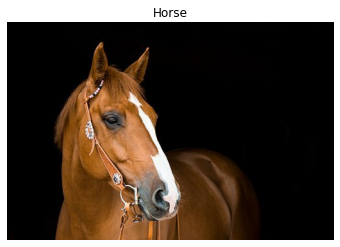

[0.]


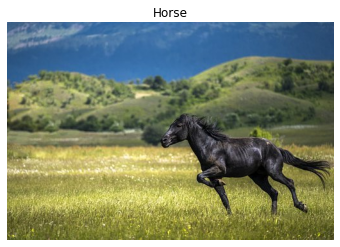

[1.]


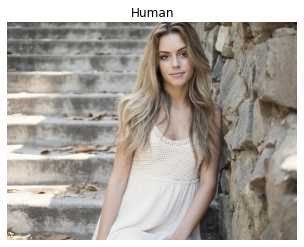

[1.]


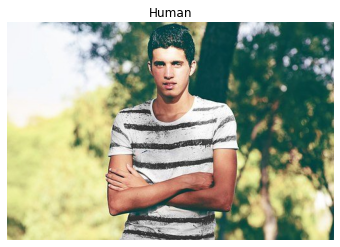

[0.]


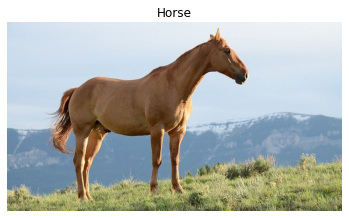

[0.]


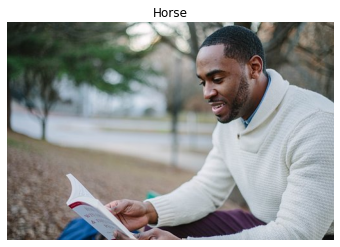

[0.]


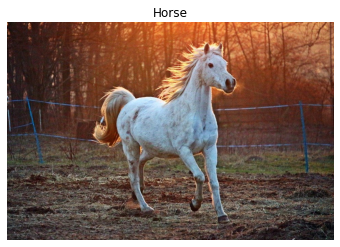

In [80]:
import numpy as np 
from keras.preprocessing import image

from PIL import Image
import requests
import matplotlib.pyplot as plt
import io

urlList = ['https://cdn.pixabay.com/photo/2016/02/15/13/26/horse-1201143__340.jpg', 'https://cdn.pixabay.com/photo/2016/11/21/16/21/abs-1846250__340.jpg', 'https://cdn.pixabay.com/photo/2020/09/25/16/50/portrait-5601950_960_720.jpg','https://cdn.pixabay.com/photo/2018/05/11/11/11/horse-3390256__340.jpg', 'https://cdn.pixabay.com/photo/2021/06/20/17/48/horse-6351668__340.jpg', 'https://cdn.pixabay.com/photo/2016/03/23/04/01/woman-1274056_960_720.jpg', 'https://cdn.pixabay.com/photo/2016/03/27/22/21/boy-1284509__340.jpg', 'https://cdn.pixabay.com/photo/2016/01/19/17/55/horse-1149974__340.jpg', 'https://cdn.pixabay.com/photo/2017/08/01/10/44/people-2564463__340.jpg', 'https://cdn.pixabay.com/photo/2017/02/13/20/21/horse-2063672_960_720.jpg']

for url in urlList:

    response = requests.get(url, stream=True)
    img = Image.open(response.raw)

    imgc = img.convert('RGB')

    imgc = imgc.resize((300,300), Image.NEAREST)
    x = image.img_to_array(imgc)

    '''plt.imshow(img)
    plt.axis('Off')
    plt.title('Image')
    plt.show()'''

    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    if classes[0]>0.5:
        plt.imshow(img)
        plt.axis('Off')
        plt.title('Human')
        plt.show()
    else:
        plt.imshow(img)
        plt.axis('Off')
        plt.title('Horse')
        plt.show()